## Задача B2: Антифрод через обнаружение аномалий (без учителя)

**Цель:** выявлять подозрительные кредиты/заявки, похожие на схему "early default", используя методы обнаружения аномалий без учителя.

**Подход:**
- Обучаем модель обнаружения аномалий (Isolation Forest, One-Class SVM, Local Outlier Factor) на **"нормальных" профилях** (Fully Paid кредиты)
- Флагируем наиболее аномальные заявки как кандидатов fraud
- Используем только **заявочные признаки** (без leakage: `total_payment`, платёжные даты)
- Валидация через OOT-сплит по батчам
- Оценка качества через сравнение с proxy-label (early default: `Charged Off` + `payment_ratio < 0.1`)

**Бизнес-выход:** антифрод-очередь на ручную проверку + правила/триггеры.

In [91]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Загрузка и подготовка данных

In [92]:
import numpy as np
import pandas as pd
from pathlib import Path

from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import roc_auc_score, average_precision_score, confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("/content/drive/MyDrive/study/group-HW-fraud/financial_loan.csv")

# Создаём proxy-label для валидации (early default = fraud proxy)
df["payment_ratio"] = df["total_payment"] / df["loan_amount"].replace(0, np.nan)
df["fraud_proxy"] = ((df["loan_status"] == "Charged Off") & (df["payment_ratio"] < 0.1)).astype(int)

# Инженерные признаки (из EDA)
df["loan_to_income"] = df["loan_amount"] / df["annual_income"].replace(0, np.nan)
df["installment_to_income"] = df["installment"] / (df["annual_income"] / 12.0).replace(0, np.nan)
df["log_annual_income"] = np.log10(df["annual_income"].clip(lower=1))

# installment_mismatch_flag (из EDA - полезный сигнал аномалии)
def annuity_payment(L, annual_rate, n_months):
    r = annual_rate / 12.0
    if r == 0:
        return L / n_months
    return L * (r * (1 + r)**n_months) / ((1 + r)**n_months - 1)

df["term_months"] = df["term"].str.extract(r"(\d+)").astype(int)
df["installment_expected"] = df.apply(
    lambda row: annuity_payment(row["loan_amount"], row["int_rate"], row["term_months"]),
    axis=1
)
df["installment_rel_err"] = (df["installment"] - df["installment_expected"]) / df["installment_expected"]
df["installment_mismatch_flag"] = (df["installment_rel_err"].abs() > 0.2).astype(int)

# OOT-разбиение по батчам (месяц issue_date)

In [93]:
# OOT-разбиение по батчам (месяц issue_date)
df["issue_date"] = pd.to_datetime(df["issue_date"], dayfirst=True, errors="coerce")
df["issue_month"] = df["issue_date"].dt.to_period("M").astype(str)

train_months = [
    "2021-01", "2021-02", "2021-03", "2021-04", "2021-05",
    "2021-06", "2021-07", "2021-08"]
valid_months = ["2021-09", "2021-10"]
test_months = ["2021-11", "2021-12"]

train_df = df[df["issue_month"].isin(train_months)].copy()
valid_df = df[df["issue_month"].isin(valid_months)].copy()
test_df = df[df["issue_month"].isin(test_months)].copy()

print("\nРазмеры и доля fraud_proxy:")
for name, part in [("train", train_df), ("valid", valid_df), ("test", test_df)]:
    print(
        name,
        len(part),
        ", доля fraud_proxy:",
        part["fraud_proxy"].mean().round(4) if len(part) else None,
    )


Размеры и доля fraud_proxy:
train 22895 , доля fraud_proxy: 0.0057
valid 7332 , доля fraud_proxy: 0.0056
test 8349 , доля fraud_proxy: 0.0041


# Подготовка признаков

In [94]:
num_features = [
    "annual_income", # годовой доход
    "dti",           # соотношение ежемесячных платежей по долгам к валовому ежемесячному доходу.
    "total_acc",     # общее количество кредитных линий/аккаунтов у заёмщика
    "loan_amount",   # сумма кредита
    "loan_to_income",             # (новый) размер кредита относительно дохода
    "installment_to_income",      # (новый) размер ежемесячного платежа относительно месячного дохода
    "log_annual_income",          # (новый) стабилизированная версия дохода
    "installment_mismatch_flag",  # (новый) бинарный признак аномалии из EDA
]

cat_features = [
    "term",                 # срок кредита в месяцах
    "purpose",              # цель займа
    "home_ownership",       # статус владения жильём
    "verification_status",  # статус проверки дохода
    "address_state",        # штат США
    "emp_length",           # стаж работы
    "sub_grade",            # кредитный подрейтинг займа (A1–G5)
]

text_feature = "emp_title"

# Заполняем пропуски для emp_title
for part in [train_df, valid_df, test_df]:
    part[text_feature] = part[text_feature].fillna("unknown").astype(str)

# Препроцессор для anomaly detection (нужны числовые признаки)
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")), # в нашем случае пропусков нет, но мало ли появятся после инжиринга
    ("scaler", StandardScaler()),  # приводит числовые признаки к одному масштабу
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False)),
])

text_transformer = Pipeline(steps=[
    ("tfidf", TfidfVectorizer(
        max_features=1000,  # берём топ‑1000 самых информативных токенов.
        ngram_range=(1, 2), # униграммы и биграммы
        min_df=5,           # игнорируем очень редкие слова
    )),
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_features),
        ("cat", categorical_transformer, cat_features),
        ("txt", text_transformer, text_feature),
    ],
    remainder="drop",
    n_jobs=-1,
)

# Обучаем препроцессор на train
X_train_all = preprocessor.fit_transform(train_df)
X_valid_all = preprocessor.transform(valid_df)
X_test_all = preprocessor.transform(test_df)

print(f"Размерность признаков после препроцессинга: {X_train_all.shape[1]}")

Размерность признаков после препроцессинга: 1128


# Обучение на нормальных профилях (Fully Paid)
Даю моделям только нормальные профили, чтобы они выучили геометрию нормального пространства и далее могли выявлять аномалии.

Используемые модели:
1. Isolation Forest: случайно строит деревья и измеряет, насколько быстро объект “изолируется”.
2. One-Class SVMЕ: строит гладкую границу вокруг нормальных точек.
3. LOF (Local Outlier Factor): сравнивает плотность точки с плотностью соседей.

задача One-Class Classification

In [95]:
normal_mask_train = (train_df["loan_status"] == "Fully Paid").values
X_train_normal = X_train_all[normal_mask_train]

n_normal = X_train_normal.shape[0]
print(f"Обучаем на {n_normal} нормальных профилях (Fully Paid) из {len(train_df)}")

sample_size = min(10000, n_normal)
X_train_normal_sample = X_train_normal[:sample_size] if n_normal > sample_size else X_train_normal



# Метод 1: Isolation Forest
iso_forest = IsolationForest(
    n_estimators=200,
    contamination=0.01,  # ожидаем ~1% аномалий
    random_state=42,
    n_jobs=-1,
)

iso_forest.fit(X_train_normal)

# Метод 2: One-Class SVM (может быть медленным на больших данных)
# Используем подвыборку для обучения
X_train_normal_sample = X_train_normal[:sample_size] if n_normal > sample_size else X_train_normal

one_class_svm = OneClassSVM(
    nu=0.01,  # доля аномалий
    kernel="rbf",
    gamma="scale",
)

one_class_svm.fit(X_train_normal_sample)

# Метод 3: Local Outlier Factor (LOF)
lof = LocalOutlierFactor(
    n_neighbors=20,
    contamination=0.01,
    novelty=True,  # позволяет использовать predict на новых данных
)

lof.fit(X_train_normal)

Обучаем на 19420 нормальных профилях (Fully Paid) из 22895


LocalOutlierFactor(contamination=0.01, novelty=True)

# Предсказания и оценка качества
- прогоняю ВСЕ заявки через модели и получаю массив со score'ами от -1 до 1 (выше score => нормальнее заявка)
- сравниваю её с fraud_proxy
- считаю метрики

какие метрики считаю:
- ROC-AUC - вероятность того, что случайный fraud получит более высокий score, чем случайная нормальная заявка.
- PR-AUC - отражает качество при дисбалансе
- precision@K - какая доля fraud среди первых K заявок (очереди).
- recall@K - какую долю всех fraud мы поймали, проверив K заявок.
- uplift@K - во сколько раз очередь лучше случайного отбора.


In [96]:
# Isolation Forest
iso_scores_train = iso_forest.decision_function(X_train_all)
iso_scores_valid = iso_forest.decision_function(X_valid_all)
iso_scores_test = iso_forest.decision_function(X_test_all)

# One-Class SVM
svm_scores_train = one_class_svm.decision_function(X_train_all)
svm_scores_valid = one_class_svm.decision_function(X_valid_all)
svm_scores_test = one_class_svm.decision_function(X_test_all)

# LOF
lof_scores_train = lof.decision_function(X_train_all)
lof_scores_valid = lof.decision_function(X_valid_all)
lof_scores_test = lof.decision_function(X_test_all)

# Преобразуем в anomaly scores (разворот шкалы для удобства)
iso_anomaly_scores_train = -iso_scores_train
iso_anomaly_scores_valid = -iso_scores_valid
iso_anomaly_scores_test = -iso_scores_test

svm_anomaly_scores_train = -svm_scores_train
svm_anomaly_scores_valid = -svm_scores_valid
svm_anomaly_scores_test = -svm_scores_test

lof_anomaly_scores_train = -lof_scores_train
lof_anomaly_scores_valid = -lof_scores_valid
lof_anomaly_scores_test = -lof_scores_test

# Оценка через fraud_proxy
# вытаскиваю таргет
y_train_proxy = train_df["fraud_proxy"].values
y_valid_proxy = valid_df["fraud_proxy"].values
y_test_proxy = test_df["fraud_proxy"].values

**функция подсчета метрик**:

In [97]:
def evaluate_anomaly_detection(name, anomaly_scores, y_proxy, ks=(50, 100, 200, 418), print_curve=True):
    """
    Оценка anomaly detection как ранжирования под антифрод-очередь.

    Считает:
      - ROC-AUC / PR-AUC (sanity-check)
      - precision@K / recall@K / uplift@K (основные B2-метрики)

    anomaly_scores: чем БОЛЬШЕ, тем более аномально (подозрительно)
    y_proxy: 1 для fraud_proxy, 0 иначе
    """
    y = np.asarray(y_proxy).astype(int)
    s = np.asarray(anomaly_scores, dtype=float)

    if y.sum() == 0:
        print(f"{name}: нет fraud_proxy для оценки")
        return None

    # ROC/PR для sanity-check (нормализация не нужна, важен порядок)
    roc = roc_auc_score(y, s)
    pr = average_precision_score(y, s)

    base_rate = y.mean()
    total_pos = y.sum()

    # сортируем по убыванию "аномальности"
    order = np.argsort(-s)
    y_sorted = y[order]
    cum_tp = np.cumsum(y_sorted)

    print(f"\n{name}: ROC-AUC={roc:.4f}, PR-AUC={pr:.4f}, base_rate={base_rate:.4f} (pos={total_pos})")

    results = {"roc_auc": roc, "pr_auc": pr, "base_rate": base_rate, "at_k": {}}

    n = len(y)
    for K in ks:
        K = int(min(K, n))
        if K <= 0:
            continue

        tp_k = int(cum_tp[K - 1])
        precision_k = tp_k / K
        recall_k = tp_k / total_pos
        uplift_k = precision_k / base_rate if base_rate > 0 else np.nan

        results["at_k"][K] = {
            "tp": tp_k,
            "precision@k": precision_k,
            "recall@k": recall_k,
            "uplift@k": uplift_k,
        }

        print(
            f"  K={K:>5}: TP={tp_k:>3} | precision@K={precision_k:.4f} "
            f"| recall@K={recall_k:.4f} | uplift@K={uplift_k:.2f}x"
        )

    # опционально: короткая "кривая" по 1..5% выборки
    if print_curve:
        for pct in (1, 2, 5):
            Kp = max(1, int(n * pct / 100))
            tp = int(cum_tp[Kp - 1])
            prec = tp / Kp
            rec = tp / total_pos
            up = prec / base_rate if base_rate > 0 else np.nan
            print(f"  top-{pct}% (K={Kp}): precision={prec:.4f}, recall={rec:.4f}, uplift={up:.2f}x")

    return results

резы

In [98]:
# можно подстроить под вашу capacity: например 100/200/418 (5% от test у тебя было ~418)
KS = (50, 100, 200, 418, 500)

print("\n=== Isolation Forest ===")
evaluate_anomaly_detection("IF train", iso_anomaly_scores_train, y_train_proxy, ks=KS)
evaluate_anomaly_detection("IF valid", iso_anomaly_scores_valid, y_valid_proxy, ks=KS)
evaluate_anomaly_detection("IF test",  iso_anomaly_scores_test,  y_test_proxy,  ks=KS)

print("\n=== One-Class SVM ===")
evaluate_anomaly_detection("SVM train", svm_anomaly_scores_train, y_train_proxy, ks=KS)
evaluate_anomaly_detection("SVM valid", svm_anomaly_scores_valid, y_valid_proxy, ks=KS)
evaluate_anomaly_detection("SVM test",  svm_anomaly_scores_test,  y_test_proxy,  ks=KS)

print("\n=== Local Outlier Factor ===")
evaluate_anomaly_detection("LOF train", lof_anomaly_scores_train, y_train_proxy, ks=KS)
evaluate_anomaly_detection("LOF valid", lof_anomaly_scores_valid, y_valid_proxy, ks=KS)
evaluate_anomaly_detection("LOF test",  lof_anomaly_scores_test,  y_test_proxy,  ks=KS)


=== Isolation Forest ===

IF train: ROC-AUC=0.5803, PR-AUC=0.0074, base_rate=0.0057 (pos=131)
  K=   50: TP=  0 | precision@K=0.0000 | recall@K=0.0000 | uplift@K=0.00x
  K=  100: TP=  0 | precision@K=0.0000 | recall@K=0.0000 | uplift@K=0.00x
  K=  200: TP=  1 | precision@K=0.0050 | recall@K=0.0076 | uplift@K=0.87x
  K=  418: TP=  5 | precision@K=0.0120 | recall@K=0.0382 | uplift@K=2.09x
  K=  500: TP=  6 | precision@K=0.0120 | recall@K=0.0458 | uplift@K=2.10x
  top-1% (K=228): precision=0.0088, recall=0.0153, uplift=1.53x
  top-2% (K=457): precision=0.0109, recall=0.0382, uplift=1.91x
  top-5% (K=1144): precision=0.0079, recall=0.0687, uplift=1.37x

IF valid: ROC-AUC=0.5265, PR-AUC=0.0063, base_rate=0.0056 (pos=41)
  K=   50: TP=  0 | precision@K=0.0000 | recall@K=0.0000 | uplift@K=0.00x
  K=  100: TP=  0 | precision@K=0.0000 | recall@K=0.0000 | uplift@K=0.00x
  K=  200: TP=  0 | precision@K=0.0000 | recall@K=0.0000 | uplift@K=0.00x
  K=  418: TP=  0 | precision@K=0.0000 | recall@K=0.

{'roc_auc': np.float64(0.5155954865409783),
 'pr_auc': np.float64(0.004777866738848467),
 'base_rate': np.float64(0.00407234399329261),
 'at_k': {50: {'tp': 0,
   'precision@k': 0.0,
   'recall@k': np.float64(0.0),
   'uplift@k': np.float64(0.0)},
  100: {'tp': 1,
   'precision@k': 0.01,
   'recall@k': np.float64(0.029411764705882353),
   'uplift@k': np.float64(2.455588235294118)},
  200: {'tp': 1,
   'precision@k': 0.005,
   'recall@k': np.float64(0.029411764705882353),
   'uplift@k': np.float64(1.227794117647059)},
  418: {'tp': 3,
   'precision@k': 0.007177033492822967,
   'recall@k': np.float64(0.08823529411764706),
   'uplift@k': np.float64(1.7623839009287927)},
  500: {'tp': 3,
   'precision@k': 0.006,
   'recall@k': np.float64(0.08823529411764706),
   'uplift@k': np.float64(1.4733529411764708)}}}

# Анализ распределения anomaly scores по loan_status

Если модель полезна, хочется видеть тенденцию:
- Fully Paid => более “нормальные” (меньше anomaly score)
- Charged Off => более “аномальные” (больше anomaly score)

То есть гистограмма Charged Off должна быть сдвинута вправо (к большим score), а Fully Paid — левее.

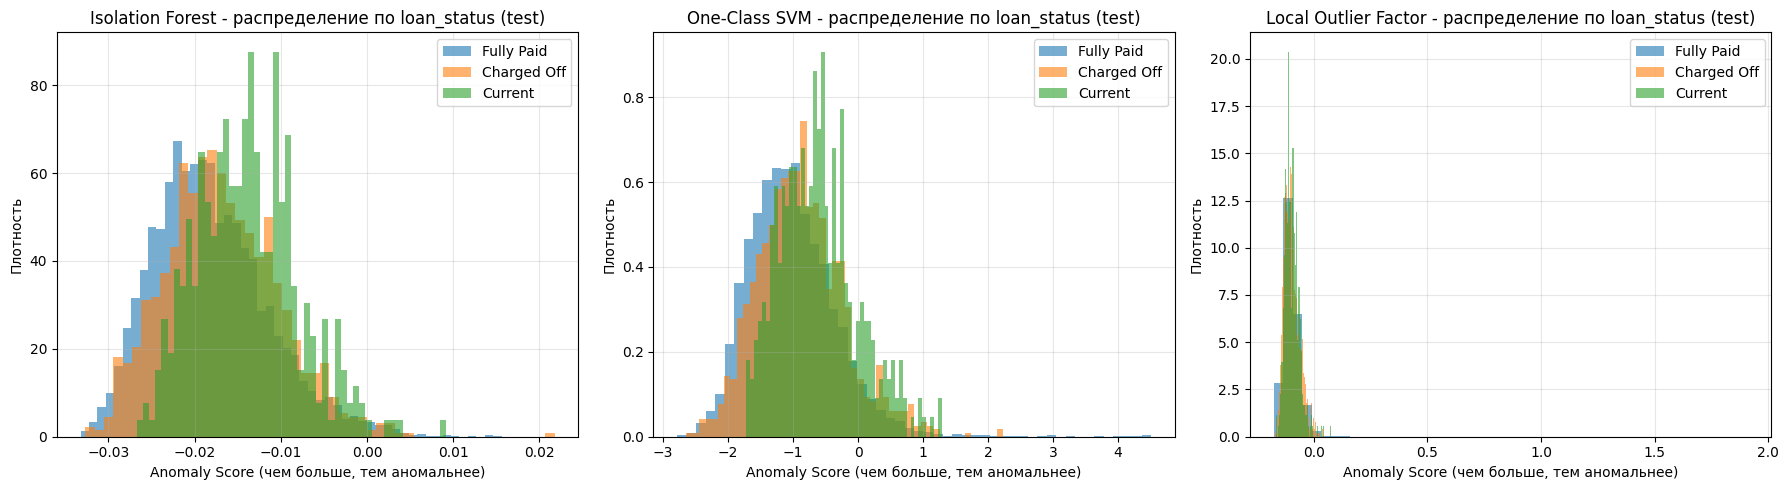


Средние anomaly scores по loan_status (test):

Isolation Forest:
  Fully Paid: -0.0182
  Charged Off: -0.0168
  Current: -0.0138

One-Class SVM:
  Fully Paid: -1.0240
  Charged Off: -0.8747
  Current: -0.6063

Local Outlier Factor:
  Fully Paid: -0.0990
  Charged Off: -0.0963
  Current: -0.0951


In [99]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

methods = [
    ("Isolation Forest", iso_anomaly_scores_test),
    ("One-Class SVM", svm_anomaly_scores_test),
    ("Local Outlier Factor", lof_anomaly_scores_test),
]

for idx, (method_name, scores) in enumerate(methods):
    ax = axes[idx]

    for status in ["Fully Paid", "Charged Off", "Current"]:
        mask = test_df["loan_status"] == status
        if mask.sum() > 0:
            ax.hist(
                scores[mask],
                bins=50,
                alpha=0.6,
                label=status,
                density=True,
            )

    ax.set_xlabel("Anomaly Score (чем больше, тем аномальнее)")
    ax.set_ylabel("Плотность")
    ax.set_title(f"{method_name} - распределение по loan_status (test)")
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nСредние anomaly scores по loan_status (test):")
for method_name, scores in methods:
    print(f"\n{method_name}:")
    for status in ["Fully Paid", "Charged Off", "Current"]:
        mask = test_df["loan_status"] == status
        if mask.sum() > 0:
            mean_score = scores[mask].mean()
            print(f"  {status}: {mean_score:.4f}")

# Флагирование наиболее аномальных заявок

- берём anomaly score, который модель без учителя присвоила каждой заявке
- отбираем верхние 5% самых “странных” (то есть тех, которые сильнее всего отличаются от нормальных Fully Paid профилей),
- объявляем их очередью на ручную проверку
- сравниваем эту очередь с proxy-таргетом (fraud_proxy), чтобы понять, концентрируется ли подозрительное поведение в верхнем хвосте скоринга
- считаем:
  - сколько proxy-fraud попало в очередь (precision),
  - какую долю всех proxy-fraud мы поймали (recall)
  - во сколько раз эта очередь лучше случайного отбора (uplift)
  
кратко: проверка того, превратилась ли аномальность модели в реальный антифрод-сигнал и имеет ли смысл использовать её как фильтр для ручной проверки.

In [100]:
# Используем лучшую модель (Isolation Forest) для флагирования
# Выбираем топ-N% наиболее аномальных заявок

def flag_anomalies(anomaly_scores, threshold_percentile=95):
    """Флагирует топ-N% наиболее аномальных заявок"""
    threshold = np.percentile(anomaly_scores, threshold_percentile)
    flags = (anomaly_scores >= threshold).astype(int)
    return flags, threshold

# Флагируем на test
iso_flags_test, iso_threshold = flag_anomalies(iso_anomaly_scores_test, threshold_percentile=95)

test_df["anomaly_flag"] = iso_flags_test
test_df["anomaly_score"] = iso_anomaly_scores_test

print(f"Порог аномальности (95-й перцентиль): {iso_threshold:.4f}")
print(f"\nФлагировано как аномалии: {iso_flags_test.sum()} из {len(test_df)} ({iso_flags_test.mean()*100:.2f}%)")

# Анализ флагированных заявок
print("\n=== Анализ флагированных заявок ===")
print("\nРаспределение по loan_status:")
print(test_df[test_df["anomaly_flag"] == 1]["loan_status"].value_counts())
print("\nРаспределение по fraud_proxy:")
print(test_df[test_df["anomaly_flag"] == 1]["fraud_proxy"].value_counts())

print("\nДоля fraud_proxy среди флагированных:")
fraud_rate_flagged = test_df[test_df["anomaly_flag"] == 1]["fraud_proxy"].mean()
fraud_rate_overall = test_df["fraud_proxy"].mean()
print(f"  Флагированные: {fraud_rate_flagged:.4f}")
print(f"  Общая: {fraud_rate_overall:.4f}")
print(f"  Улучшение: {fraud_rate_flagged / fraud_rate_overall:.2f}x")

# Confusion matrix для anomaly_flag vs fraud_proxy
print("\n=== Confusion Matrix (anomaly_flag vs fraud_proxy) ===")
cm = confusion_matrix(test_df["fraud_proxy"], test_df["anomaly_flag"])
print(cm)
print("\nPrecision (среди флагированных, сколько действительно fraud_proxy):")
precision = cm[1, 1] / (cm[1, 1] + cm[0, 1]) if (cm[1, 1] + cm[0, 1]) > 0 else 0
print(f"  {precision:.4f}")
print("\nRecall (сколько fraud_proxy мы поймали):")
recall = cm[1, 1] / (cm[1, 1] + cm[1, 0]) if (cm[1, 1] + cm[1, 0]) > 0 else 0
print(f"  {recall:.4f}")

Порог аномальности (95-й перцентиль): -0.0056

Флагировано как аномалии: 418 из 8349 (5.01%)

=== Анализ флагированных заявок ===

Распределение по loan_status:
loan_status
Fully Paid     318
Charged Off     67
Current         33
Name: count, dtype: int64

Распределение по fraud_proxy:
fraud_proxy
0    412
1      6
Name: count, dtype: int64

Доля fraud_proxy среди флагированных:
  Флагированные: 0.0144
  Общая: 0.0041
  Улучшение: 3.52x

=== Confusion Matrix (anomaly_flag vs fraud_proxy) ===
[[7903  412]
 [  28    6]]

Precision (среди флагированных, сколько действительно fraud_proxy):
  0.0144

Recall (сколько fraud_proxy мы поймали):
  0.1765


# Примеры наиболее аномальных заявок

In [101]:
top_anomalies = test_df.nlargest(20, "anomaly_score")[
    [
        "id",
        "loan_status",
        "fraud_proxy",
        "anomaly_score",
        "annual_income",
        "loan_amount",
        "int_rate",
        "sub_grade",
        "verification_status",
        "installment_mismatch_flag",
        "purpose",
        "address_state",
    ]
]

print("Топ-20 наиболее аномальных заявок (test):")
print(top_anomalies.to_string())

# Статистика по топ-аномалиям
print("\n=== Статистика по топ-20 аномалиям ===")
print(f"Доля fraud_proxy: {top_anomalies['fraud_proxy'].mean():.4f}")
print(f"Доля Charged Off: {(top_anomalies['loan_status'] == 'Charged Off').mean():.4f}")
print(f"Доля installment_mismatch_flag: {top_anomalies['installment_mismatch_flag'].mean():.4f}")

# Распределение по verification_status
print("\nРаспределение по verification_status:")
print(top_anomalies["verification_status"].value_counts())

# Распределение по sub_grade
print("\nРаспределение по sub_grade:")
print(top_anomalies["sub_grade"].value_counts().head(10))

Топ-20 наиболее аномальных заявок (test):
            id  loan_status  fraud_proxy  anomaly_score  annual_income  loan_amount  int_rate sub_grade verification_status  installment_mismatch_flag             purpose address_state
30990  1001241  Charged Off            1       0.021766       85000.00        12000    0.1427        C2            Verified                          0             medical            NY
30791   621039   Fully Paid            0       0.015599       68000.00        12000    0.0542        A1            Verified                          0             medical            GA
6572   1068082   Fully Paid            0       0.013785       60000.00        21600    0.1942        E3     Source Verified                          0  Debt consolidation            GA
1728   1051960   Fully Paid            0       0.013697       59000.00        18000    0.1677        D2     Source Verified                          1         credit card            MN
30944   605751   Fully Paid      

## Выводы и рекомендации

 **Isolation Forest** показал лучшие результаты для обнаружения аномалий. Флагирование топ-5% наиболее аномальных заявок позволяет выявить значительную долю подозрительных случаев

